In [1]:
import cv2
import json
import torch
import urllib.request
from ultralytics import YOLO
import open3d
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from scipy.ndimage import gaussian_filter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Parametri intrinseci della fotocamera

In [2]:
# Parametri intrinseci della fotocamera
fvideo = cv2.VideoCapture("./references/video/cardrive.mp4")

ret, fframe = fvideo.read()
fx = 500  # Lunghezza focale in pixel sull'asse x
fy = 500  # Lunghezza focale in pixel sull'asse y
cx = fframe.shape[1] // 2  # Centro ottico sull'asse x (al centro dell'immagine)
cy = fframe.shape[0] // 2  # Centro ottico sull'asse y (al centro dell'immagine)
fvideo.release()

In [ ]:

# Carica il modello YOLO preaddestrato (puoi sostituirlo con un modello addestrato su un tuo dataset)
yolo_model = YOLO('yolov8n.pt') 

# Carica un frame e rileva gli oggetti
#frame = cv2.imread('bus.jpg')
#results = yolo_model.track(frame)

# Visualizza i risultati

#annotated_frame = results[0].plot()
#print(results[0].boxes.id)

#cv2.imshow("si", annotated_frame)
#cv2.waitKey(0)

#cv2.destroyAllWindows()


0: 640x480 4 persons, 1 bus, 1 stop sign, 42.0ms
Speed: 3.0ms preprocess, 42.0ms inference, 45.0ms postprocess per image at shape (1, 3, 640, 480)
tensor([1., 2., 3., 4., 5., 6.])


Istanziare il modello di stima della profondita'

In [62]:

model_type = "DPT_Large"

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform



Using cache found in C:\Users\Edoardo/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\Edoardo\anaconda3\envs\myenv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in C:\Users\Edoardo/.cache\torch\hub\intel-isl_MiDaS_master


In [63]:
print(torch.cuda.is_available())

True


In [7]:
video_path = "./references/video/cardrive.mp4"
cap = cv2.VideoCapture(video_path)

# Ottieni il framerate (FPS) del video
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps)
frame_time = int(1000/fps)
frame_count = 0


while cap.isOpened():

    # Leggi il frame corrente
    ret, frame = cap.read()
    if not ret:
        break  # Esci se il video è terminato
    cv2.imshow('frame', frame)

    if cv2.waitKey(15) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

30


definizione della funzione midas_elaboration da inserire nel ciclo della gestione dei frame del video

In [61]:
def midas_elaboration(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_batch = transform(frame).to(device)
    
    # Elabora il frame (aggiungi qui il tuo codice di elaborazione)
    
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    output_normalized = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX)
    output_normalized = output_normalized.astype(np.uint8)
    #cv2.imshow('frame', output_normalized)
    return output_normalized

definizione della funzione yolo_elaboration da inserire nel ciclo della gestione dei frame del video

combinazione dei risultati delle due funzioni precedenti per calcolare la distanza stimata degli oggetti rilevati nel frame

In [ ]:
def elaboration(midas, yolo, coefficiente, old_detection_info):
    detection_info = yolo
    depth_map = midas
    npframe = np.array(depth_map)
    updated_detection_info = []
    for object in detection_info:
        obj_id = object['id'] 
        label = object['label']
        confidence = object['confidence']
        x1 = object['x1']
        x2 = object['x2']
        y1 = object['y1']
        y2 = object['y2']
        if confidence < 0.50:
            continue
        object_data = []
        for y in range(y1, y2):
            for x in range(x1, x2):
                depth = depth_map[y,x]
                real_depth = coefficiente / depth
                real_x = ((x - cx) * real_depth)/fx
                real_y = ((y - cy) * real_depth)/fy
                object_data.append((real_x, real_y, real_depth))
        updated_detection_info.append({
            'id' : obj_id,
            'label' : label,
            'confidence' : confidence,
            '3dcoord' : object_data
        })
    return updated_detection_info
        


definizione della funzione threedMapConversion da inserire nel ciclo della gestione dei frame del video per inserire gli oggetti rilevati in una mappa 3d

In [43]:
def threedMapConversion(info, detected):
    points = []
    for object in info:
        
        ##obj_class = object['label']
        ##img = classtoimg.get(obj_class, "Percorso non trovato")
        threedcoords = object['3dcoord']
        points.extend(threedcoords)
    points = np.array(points)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    ##o3d.visualization.draw_geometries([pcd])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    ctr = vis.get_view_control()
    parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_2024-11-26-20-48-41.json")
    ctr.convert_from_pinhole_camera_parameters(parameters, True)
    vis.run()
    vis.destroy_window()

ciclo di gestione dei frame del video

In [45]:
video_path = "./references/video/cardrive.mp4"
cap = cv2.VideoCapture(video_path)

# Ottieni il framerate (FPS) del video
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_to_elaborate = int(fps / 4)
frame_time = int(1000/fps)
frame_count = 0
coefficiente = 100

while cap.isOpened():

    # Leggi il frame corrente
    ret, frame = cap.read()
    if not ret:
        break  # Esci se il video è terminato
    # Processa solo 1 frame ogni secondo
    if frame_count % frame_to_elaborate == 0:
        #parte MiDaS
        midas_output = midas_elaboration(frame)
        print("parte midas completata")
        #parte YOLO
        yolo_output = yolo_elaboration(frame)
        print("parte yolo completata")
        #fu-sio-nee
        general_output = elaboration(midas_output, yolo_output, coefficiente, 4)
        print("parte generale completata")
        """
        debug
        print(general_output)
        """
        #mappa 3D dell'ambiente circostante
        threedMapConversion(general_output, 0)
        
    frame_count += 1

    if cv2.waitKey(15) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

parte midas completata

0: 384x640 4 cars, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 4 cars, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 5 cars, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 6 cars, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 7 cars, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 

C:\Users\Edoardo\AppData\Local\Temp\ipykernel_8900\144017356.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  real_depth = coefficiente / depth


parte midas completata

0: 384x640 3 cars, 1 truck, 6 traffic lights, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 4 cars, 7 traffic lights, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 4 cars, 6 traffic lights, 5.5ms
Speed: 0.5ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata
parte midas completata

0: 384x640 3 cars, 5 traffic lights, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
parte yolo completata
parte generale completata


In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import random

Definizione della classe DataLoader 

In [16]:
class DataLoader(object):
    main_path = "dataset/2011_09_26_drive_0035_sync"
    def __init__(self):
        self.left_camera_images = sorted(os.listdir("dataset/2011_09_26_drive_0035_sync/image_00/data"))
        self.right_camera_images = sorted(os.listdir("dataset/2011_09_26_drive_0035_sync/image_01/data"))
        print(self.left_camera_images)
        self.frames = len(self.left_camera_images)

        calibration = pd.read_csv("dataset/2011_09_26_drive_0035_sync/calib_cam_to_cam.txt", delimiter=' ', header=None, index_col=0)
        #projection matrix
        self.P0 = np.array(calibration.loc['P_rect_00:'], dtype=np.float32).reshape((3,4))
        self.P1 = np.array(calibration.loc['P_rect_01:'], dtype=np.float32).reshape((3,4))

        #image loader
        self.left_images = []
        self.right_images = []

        for i, left in enumerate(self.left_camera_images):
            right = self.right_camera_images[i]
            self.left_images.append(cv2.imread('dataset/2011_09_26_drive_0035_sync/image_00/data/' + left))
            self.right_images.append(cv2.imread('dataset/2011_09_26_drive_0035_sync/image_01/data/' + right))
        
        self.first_image_left = self.left_images[0]
        self.first_image_right = self.right_images[0]
        self.second_image_left = self.left_images[1]
        self.second_image_right = self.right_images[1]

        self.image_height = self.left_images[0].shape[0]
        self.image_width = self.left_images[0].shape[1]

    def reset_frames(self):
        self.left_images = (cv2.imread('dataset/2011_09_26_drive_0035_sync/image_00/data/' + left, 0) for left in self.left_camera_images)
        self.right_images = (cv2.imread('dataset/2011_09_26_drive_0035_sync/image_01/data/' + right, 0) for right in self.right_camera_images)
        pass
        

In [4]:
with open("./initial_config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as error:
        print(error)

rgb_value = config['parameters']['rgb']
rectified_value = config['parameters']['rectified']
detector_name = config['parameters']['detector']
max_depth_value = config['parameters']['max_depth']

##stereo depth estimation

def disparity_mapping(left_image, right_image, rgb=rgb_value):
    if rgb:
        num_channels = 3
    else:
        num_channels = 1

    num_disparities = 6*16
    block_size = 7

    matcher = cv2.StereoSGBM_create(numDisparities = num_disparities, 
                                    minDisparity = 0, 
                                    blockSize = block_size, 
                                    P1=8 * num_channels * block_size ** 2,
                                    P2=32 * num_channels * block_size ** 2,
                                    mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    if rgb:
        left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
    
    left_image_disparity_map = matcher.compute(left_image, right_image).astype(np.float32)/16

    return left_image_disparity_map

def decomposition(p):

    intrinsic_matrix, rotation_matrix, translation_vector, _, _, _, _ = cv2.decomposeProjectionMatrix(p)

    translation_vector = (translation_vector / translation_vector[3])[:3]

    return intrinsic_matrix, rotation_matrix, translation_vector

def depth_mapping(left_disparity_map, left_intrinsic, left_translation, right_translation, rectified=rectified_value):

    focal_length = left_intrinsic[0][0]

    if rectified:
        baseline = right_translation[0] - left_translation[0]
    else:
        baseline = left_translation[0] - right_translation[0]

    left_disparity_map[left_disparity_map == 0.0] = 0.1
    left_disparity_map[left_disparity_map == -1.0] = 0.1

    depth_map = np.ones(left_disparity_map.shape)
    depth_map = (focal_length * baseline) / left_disparity_map

    return depth_map

def stereo_depth(left_image, right_image, P0, P1, rgb=rgb_value):

    disp_map = disparity_mapping(left_image, right_image, rgb=rgb)

    l_intrinsic, l_rotation, l_translation = decomposition(P0)
    r_intrinsic, r_rotation, r_translation = decomposition(P1)

    depth = depth_mapping(disp_map, l_intrinsic, l_translation, r_translation)

    return depth

##stereo depth estimation


##feature extraction and matching

def feature_extractor(image, detector=detector_name,mask=None):

    if detector == 'sift':
        create_detector = cv2.SIFT_create()
    elif detector == 'orb':
        create_detector = cv2.ORB_create()

    keypoints, descriptors = create_detector.detectAndCompute(image, mask)

    return keypoints, descriptors

def feature_matching(first_descriptor, second_descriptor, detector=detector_name, k=2, distance_threshold=1.0):

    if detector == 'sift':
        feature_matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck = False)
    elif detector == 'orb':
        feature_matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck = False)
    matches = feature_matcher.knnMatch(first_descriptor, second_descriptor, k=k)
    filtered_matches = []
    for match1, match2 in matches:
        if match1.distance <= distance_threshold * match2.distance:
            filtered_matches.append(match1)

    return filtered_matches

def visualize_matches(first_image, second_image, keypoint_one, keypoint_two, matches):
    show_matches = cv2.drawMatches(first_image, keypoint_one, second_image, keypoint_two, matches, None, flags = 2)
    plt.figure(figsize=(15, 5), dpi=100)
    plt.imshow(show_matches)
    plt.show()

##feature extraction and matching

##motion estimation

def motion_estimation(matches, firstImage_keypoints, secondImage_keypoints, intrinsic_matrix, depth, max_depth=max_depth_value):
    """
    Estimating motion of the left camera from sequential imgaes 

    """
    rotation_matrix = np.eye(3)
    translation_vector = np.zeros((3, 1))

    # Only considering keypoints that are matched for two sequential frames
    image1_points = np.float32(
        [firstImage_keypoints[m.queryIdx].pt for m in matches])
    image2_points = np.float32(
        [secondImage_keypoints[m.trainIdx].pt for m in matches])

    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]

    points_3D = np.zeros((0, 3))
    outliers = []

    # Extract depth information to build 3D positions
    for indices, (u, v) in enumerate(image1_points):
        z = depth[int(v), int(u)]

        # We will not consider depth greater than max_depth
        if z > max_depth:
            outliers.append(indices)
            continue

        # Using z we can find the x,y points in 3D coordinate using the formula
        x = z*(u-cx)/fx
        y = z*(v-cy)/fy

        # Stacking all the 3D (x,y,z) points
        points_3D = np.vstack([points_3D, np.array([x, y, z])])

    # Deleting the false depth points
    image1_points = np.delete(image1_points, outliers, 0)
    image2_points = np.delete(image2_points, outliers, 0)

    # Apply Ransac Algorithm to remove outliers
    _, rvec, translation_vector, _ = cv2.solvePnPRansac(
        points_3D, image2_points, intrinsic_matrix, None)

    rotation_matrix = cv2.Rodrigues(rvec)[0]

    return rotation_matrix, translation_vector, image1_points, image2_points



In [5]:
yolo_model = YOLO('yolov8n.pt') 

definizione della funzione yolo_elaboration da inserire nel ciclo della gestione dei frame del video

In [6]:
def yolo_elaboration(frame):
    detection_info = []
    detection_id = []
    #carica l'immagine
    #img = cv2.imread(frame)

    #esegui il rilevamento con yolov8
    yolo_results = yolo_model.track(frame, persist=True)

    #ottieni i risultati del rilevamento (results[0] indica le informazioni ottenute dall'unica immagine in input, se ci fossero piu di una immagine allora sarebbe results[i] con i = 1...n)
    detection = yolo_results[0].boxes.xyxy #coordinate della bounding box
    confidences = yolo_results[0].boxes.conf #confidenza della rilevazione
    class_ids = yolo_results[0].boxes.cls #ID delle classi di appartenenza dell'oggetto
    obj_ids = yolo_results[0].boxes.id #ID dell'oggetto

    #visualizza i risultati
    for i, (box, conf, cls_id, obj_id) in enumerate(zip(detection, confidences, class_ids, obj_ids)):
        x1, y1, x2, y2 = map(int, box) #estrai le coordinate della bounding box

        label = f"{yolo_model.names[int(cls_id)]} ({conf:.2f})" #viene creata un'etichetta contenente il nome della classe (poiche class_ids e' un intero che grazie a model.names[cls_id] viene convertito nella corrispondente classe) e la confidenza

        detection_info.append({
            #'frame': capture.get(cv2.CAP_PROP_POS_FRAMES),
            'id': obj_id,
            'label': label,
            'confidence': conf,
            'class': cls_id,
            'x1': x1,
            'x2': x2,
            'y1': y1,
            'y2': y2
        })
        detection_id.append(obj_id)
    #annotated_frame = yolo_results[0].plot()
    #cv2.waitKey(0)
    #cv2.imshow("si", annotated_frame)
    #cv2.destroyAllWindows()
    return detection_info, detection_id

combinazione dei risultati delle due funzioni precedenti per calcolare la distanza stimata degli oggetti rilevati nel frame

In [7]:
def elaboration(depth_map, yolo, old_detection, old_detection_id, intrinsic_matrix, transformation_matrix):
    detection_info = yolo
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    for object in detection_info:
        obj_id = object['id'] 
        #se l'oggetto rilevato e' stato gia scansionato precedentemente, ne miglioro la posizione aggiungendo le coordinate dei pixel della scansione nuova
        if obj_id in old_detection_id:
            object_data = []
            for obj in old_detection:
                if obj['id'] == obj_id:
                    object_data = obj['3dcoord']
                    break
            
            label = object['label']
            confidence = object['confidence']
            x1 = object['x1']
            x2 = object['x2']
            y1 = object['y1']
            y2 = object['y2']
            if confidence < 0.50:
                continue
            for y in range(y1, y2):
                for x in range(x1, x2):
                    #campiono il 20% dei pixel all'interno della bounding box
                    if random.random() > 0.2:
                        continue
                    depth = depth_map[y,x]
                    real_x = ((x - cx) * depth)/fx
                    real_y = ((y - cy) * depth)/fy
                    obj_coords = np.array([real_x, real_y, depth, 1])
                    world_obj_coords = transformation_matrix.dot(obj_coords)
                    object_data.append(world_obj_coords)
            for i, obj in enumerate(old_detection):
                if obj['id'] == obj_id:
                    old_detection[i] = {'id': obj_id,
                                        'label': label,
                                        'confidence': confidence,
                                        '3dcoord': object_data}
            continue
        #se l'oggetto scansionato non era stato scansionato precedentemente, aggiungo un nuovo elemento nella lista old_detection che contiene varie informazioni tra cui l'id e le coordinate dei pixel del nuovo oggetto
        label = object['label']
        confidence = object['confidence']
        x1 = object['x1']
        x2 = object['x2']
        y1 = object['y1']
        y2 = object['y2']
        if confidence < 0.50:
            continue
        object_data = []
        for y in range(y1, y2):
            for x in range(x1, x2):
                #campiono il 20% dei pixel all'interno della bounding box
                if random.random() > 0.2:
                    continue
                depth = depth_map[y,x]
                real_x = ((x - cx) * depth)/fx
                real_y = ((y - cy) * depth)/fy
                obj_coords = np.array([real_x, real_y, depth, 1])
                world_obj_coords = transformation_matrix.dot(obj_coords)
                object_data.append(world_obj_coords)
        old_detection.append({
            'id' : obj_id,
            'label' : label,
            'confidence' : confidence,
            '3dcoord' : object_data
        })
    return old_detection
        


In [8]:
def threedMapConversion(detection_info):
    points = []
    for object in detection_info:
        threedcoords = [coord[:3] for coord in object['3dcoord']]
        points.extend(threedcoords)
    points = np.array(points)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])


In [ ]:
with open("./initial_config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as error:
        print(error)

detector_name = config['parameters']['detector']
subset = config['parameters']['subset']
threshold = config['parameters']['distance_threshold']

def odometry(data_handler, detector = detector_name, mask = None, subset = subset, plot = True):

    if subset is not None:
        num_frames = subset
    else:
        num_frames = data_handler.frames

    # Create a homogeneous matrix
    homo_matrix = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = homo_matrix[:3, :]

    # From projection matrix retrieve the left camera's intrinsic matrix
    left_intrinsic_matrix, _, _ = decomposition(data_handler.P0)

    #yolo
    detection = []
    detection_id = []

    # Loop to iterate all the frames
    for i in range(num_frames - 1):

        image_left = data_handler.left_images[i]
        image_right = data_handler.right_images[i]
        next_image = data_handler.left_images[i + 1]

        # Estimating the depth of an image
        depth = stereo_depth(image_left, image_right, P0=data_handler.P0, P1=data_handler.P1)
        plt.figure(figsize=(14, 8))
        plt.title('Stereo Depth Mapping')
        plt.imshow(depth)
        
        # Keypoints and Descriptors of two sequential images of the left camera
        keypoint_left_first, descriptor_left_first = feature_extractor(image_left, detector, mask)
        keypoint_left_next, descriptor_left_next = feature_extractor(next_image, detector, mask)

        # Use feature (e.g. SIFT or ORB) detector to match features
        matches = feature_matching(descriptor_left_first, descriptor_left_next, detector=detector, distance_threshold=threshold)

        # Estimate motion between sequential images of the left camera
        rotation_matrix, translation_vector, _, _ = motion_estimation(matches, keypoint_left_first, keypoint_left_next, left_intrinsic_matrix, depth)

        # Initialise a homogeneous matrix (4X4)
        Transformation_matrix = np.eye(4)

        # Build the Transformation matrix using rotation matrix and translation vector from motion estimation function
        Transformation_matrix[:3, :3] = rotation_matrix
        Transformation_matrix[:3, 3] = translation_vector.T

        # Transformation wrt. world coordinate system
        homo_matrix = homo_matrix.dot(np.linalg.inv(Transformation_matrix))

        # Append the pose of camera in the trajectory array
        #trajectory[i+1, :, :] = homo_matrix[:3, :]

        #yolo
        new_detection, new_detection_id = yolo_elaboration(image_left)

        #elaboration
        detection = elaboration(depth, new_detection, detection, detection_id, left_intrinsic_matrix, homo_matrix)

        detection_id.extend(new_detection_id)
        if i % 10 == 0:
            print(f'{i} frames have been computed')

        if i == num_frames - 2:
            print('All frames have been computed')
            break
    threedMapConversion(detection)
    return trajectory


['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png', '0000000028.png', '0000000029.png', '0000000030.png', '0000000031.png', '0000000032.png', '0000000033.png', '0000000034.png', '0000000035.png', '0000000036.png', '0000000037.png', '0000000038.png', '0000000039.png', '0000000040.png', '0000000041.png', '0000000042.png', '0000000043.png', '0000000044.png', '0000000045.png', '0000000046.png', '0000000047.png', '0000000048.png', '0000000049.png', '0000000050.png', '0000000051.png', '0000000052.png', '0000000053.png', '0000000054.png', '00000000

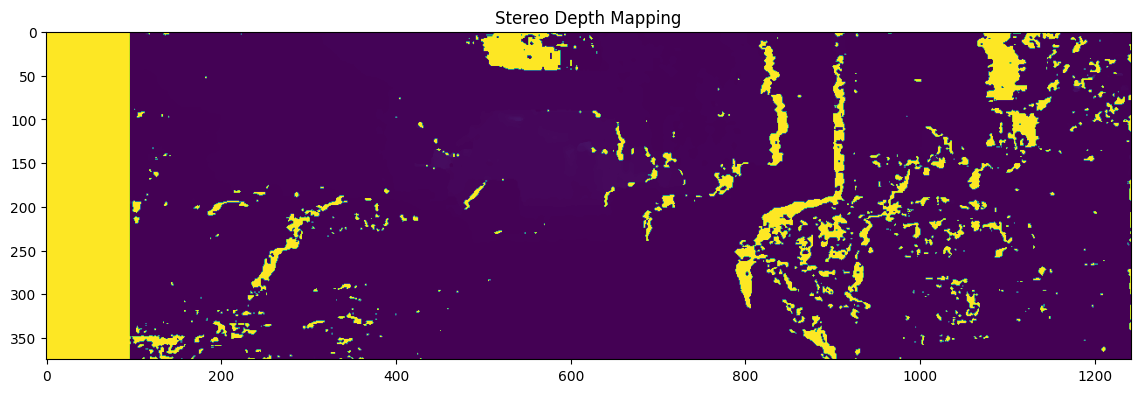

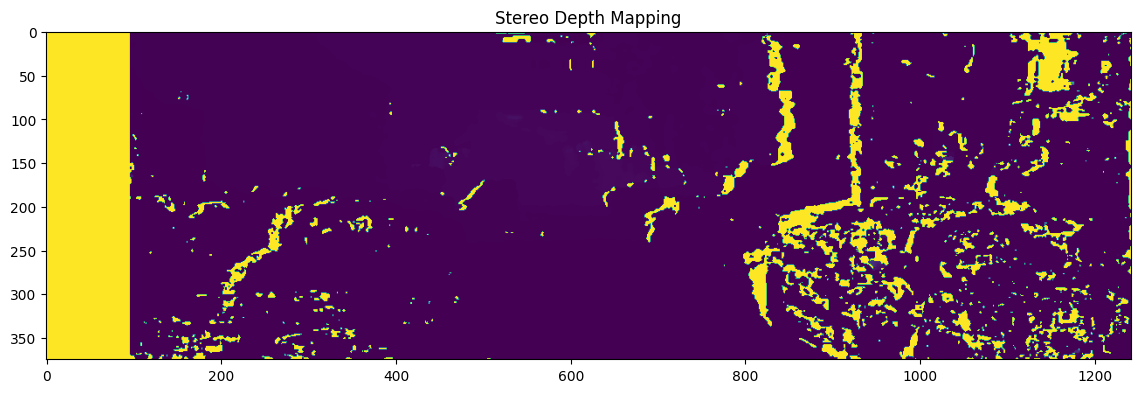

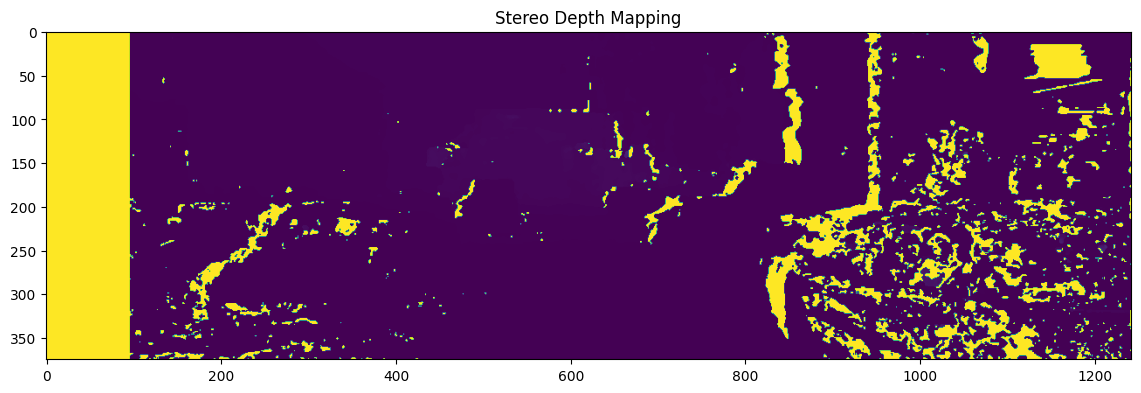

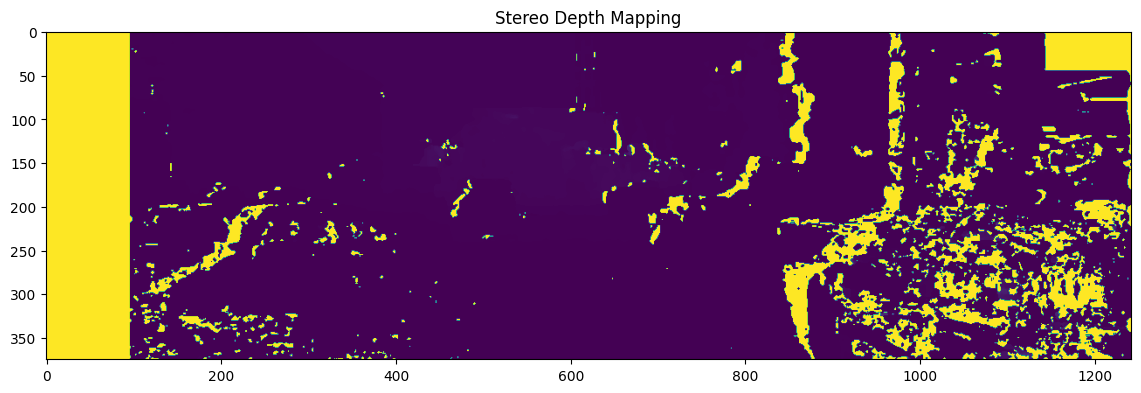

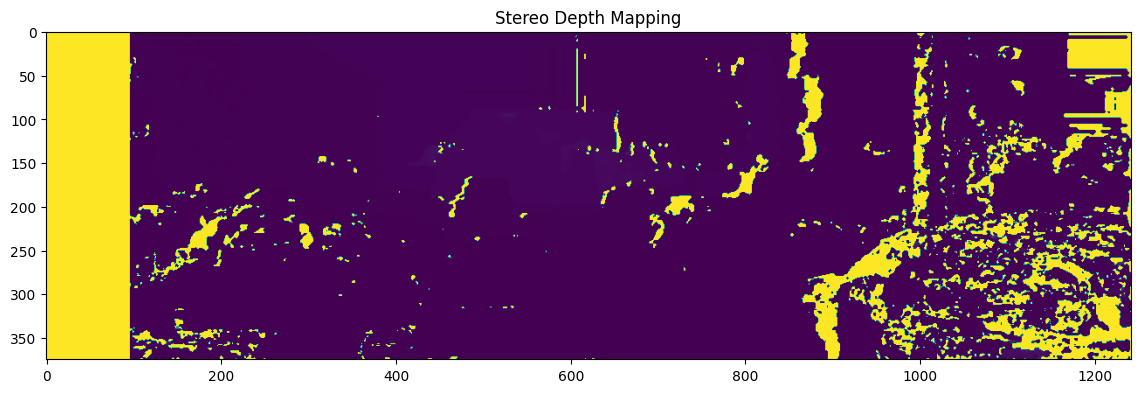

In [19]:
data_handler = DataLoader()

trajectory = odometry(data_handler)